=== BEFORE Removing Stop Words ===
Total summaries after removing duplicates: 667
Total words (with stop words): 142582
Top 10 most common words (with stop words): [('the', 8525), ('we', 4116), ('of', 4082), ('and', 4012), ('to', 3308), ('is', 2638), ('a', 2603), ('data', 2415), ('in', 2142), ('for', 1408)]

Short Summaries (less than 5 words):
     SerialNo              Session_Summary
627       628  paper discussion of midsem 

=== AFTER Removing Stop Words ===
Total words (without stop words): 89612
Top 10 most common words (without stop words): [('data', 2415), ('regression', 1010), ('model', 910), ('values', 669), ('sample', 616), ('value', 585), ('linear', 557), ('mean', 527), ('class', 520), ('features', 507)]
📊 Character Count Stats:
 count     667.000000
mean      974.142429
std       653.912486
min        23.000000
25%       555.000000
50%       819.000000
75%      1193.000000
max      7350.000000
Name: char_count, dtype: float64

📊 Word Count Stats:
 count    667.000000
mean

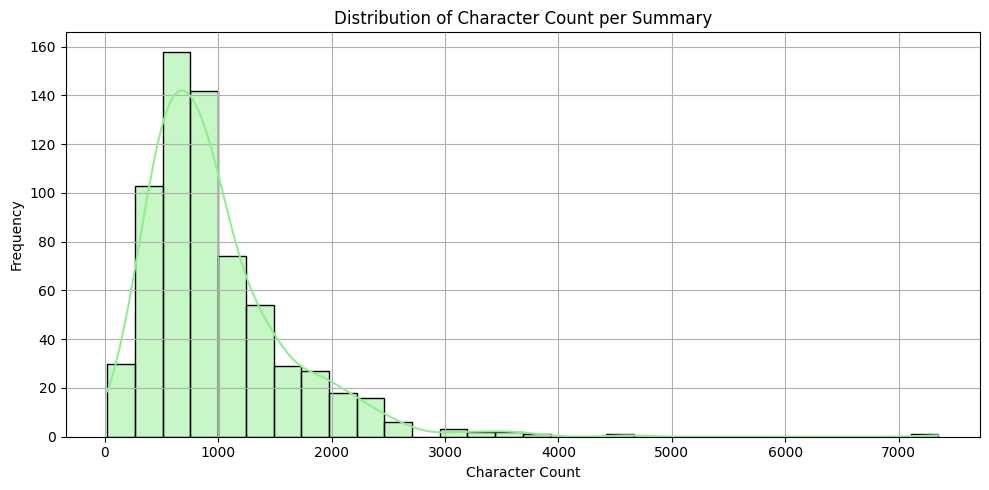

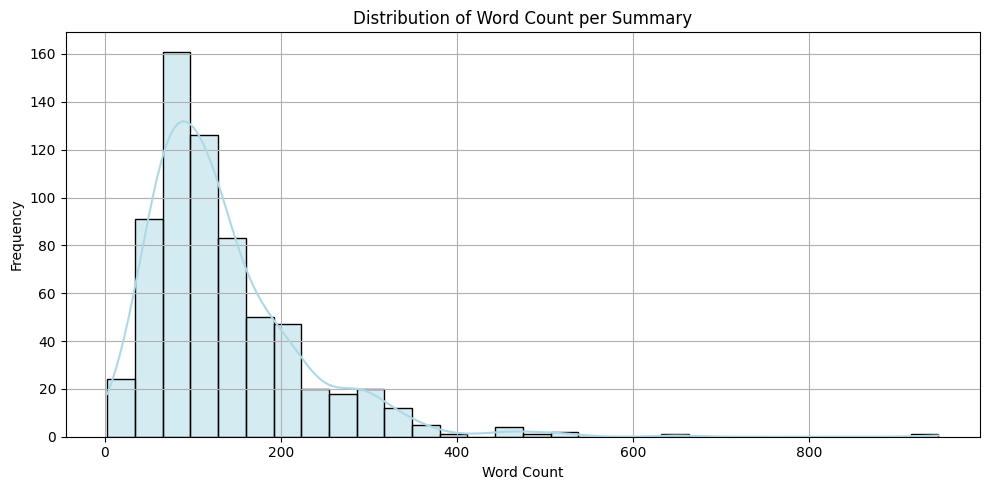

NameError: name 'cosine_sim_matrix_tfidf' is not defined

In [ ]:
import pandas as pd
import re
import html
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow_hub as hub
import tensorflow as tf
from sentence_transformers import SentenceTransformer
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# ----------- Load and Preprocess Data ------------------
file_path = "Session-Summary-for-E6-project.xlsx"
df = pd.read_excel(file_path)

df['Session_Summary'] = df['Session_Summary'].str.lower()
df = df.drop_duplicates(subset='Session_Summary')

# ----------- Clean text: Remove HTML entities, non-ASCII, extra spaces -----------
def clean_text(text):
    text = html.unescape(text)                    # Handle encoded HTML symbols
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)    # Remove non-ASCII characters (e.g. â€™)
    text = re.sub(r'\s+', ' ', text)              # Remove extra whitespace
    return text.strip()

df['Cleaned_Summary'] = df['Session_Summary'].astype(str).apply(clean_text)

# ----------- Tokenization & Stop Word Removal -----------
stop_words = set([
    'the', 'then', 'how', 'if', 'about', 'we', 'of', 'and', 'to', 'is', 'a', 'in', 'for', 'on', 'with', 'as',
    'at', 'this', 'that', 'it', 'by', 'an', 'be', 'are', 'was', 'were', 'from', 'or', 'our', 'which', 'their',
    'has', 'have', 'had', 'but', 'also', 'not', 'they', 'you', 'i', 'so', 'its', 'will', 'can', 'may', 'do', 'did'
])

def tokenize(text):
    return re.findall(r'\b\w+\b', text)

df['Tokens'] = df['Cleaned_Summary'].apply(tokenize)
df['Word_Count'] = df['Tokens'].apply(len)

all_words = [word for tokens in df['Tokens'] for word in tokens]
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(10)
total_words_before = len(all_words)

df['Is_Short'] = df['Word_Count'] < 5
short_summaries = df[df['Is_Short']]

df['Tokens_Cleaned'] = df['Tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
df['Word_Count_Cleaned'] = df['Tokens_Cleaned'].apply(len)
df['Cleaned_Summary'] = df['Tokens_Cleaned'].apply(lambda tokens: ' '.join(tokens))

cleaned_words = [word for tokens in df['Tokens_Cleaned'] for word in tokens]
cleaned_word_freq = Counter(cleaned_words)
most_common_cleaned = cleaned_word_freq.most_common(10)
total_words_after = len(cleaned_words)

print("=== BEFORE Removing Stop Words ===")
print("Total summaries after removing duplicates:", df.shape[0])
print("Total words (with stop words):", total_words_before)
print("Top 10 most common words (with stop words):", most_common_words)
print("\nShort Summaries (less than 5 words):")
print(short_summaries[['SerialNo', 'Session_Summary']])

print("\n=== AFTER Removing Stop Words ===")
print("Total words (without stop words):", total_words_after)
print("Top 10 most common words (without stop words):", most_common_cleaned)

# ----------- Character and Word Count Analysis -----------

# Character and word count for each summary
df['char_count'] = df['Cleaned_Summary'].apply(len)
df['word_count'] = df['Cleaned_Summary'].apply(lambda x: len(str(x).split()))

# Basic statistics
print("📊 Character Count Stats:\n", df['char_count'].describe())
print("\n📊 Word Count Stats:\n", df['word_count'].describe())

# Plotting character count distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['char_count'], bins=30, kde=True, color='lightgreen')
plt.title("Distribution of Character Count per Summary")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting word count distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=30, kde=True, color='lightblue')
plt.title("Distribution of Word Count per Summary")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------- TF-IDF -----------
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Cleaned_Summary'])

# ----------- USE -----------
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
original_summaries = df['Session_Summary'].tolist()
summary_embeddings_use = embed(original_summaries).numpy()

# ----------- SBERT -----------
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
summary_embeddings_sbert = sbert_model.encode(original_summaries)
cosine_sim_matrix_sbert = cosine_similarity(summary_embeddings_sbert)

# -----------  Full Cosine Similarity Matrices -----------
cosine_sim_matrix_tfidf = cosine_similarity(tfidf_matrix)
cosine_sim_matrix_use = cosine_similarity(summary_embeddings_use)
cosine_sim_matrix_sbert = cosine_similarity(summary_embeddings_sbert)

# ----------- Compare Same Random Pairs for All 3 Methods -----------
def get_fixed_random_pairs(n, num_pairs=5):
    possible_pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]
    return random.sample(possible_pairs, min(num_pairs, len(possible_pairs)))

def compare_same_pairs_all_methods(df, pairs, sim_tfidf, sim_use, sim_sbert):
    print(f"\n🔗 Comparing Same {len(pairs)} Random Summary Pairs Across TF-IDF, USE, and SBERT:\n")

    for (i, j) in pairs:
        tfidf_score = sim_tfidf[i][j]
        use_score = sim_use[i][j]
        sbert_score = sim_sbert[i][j]

        print(f"📝 Pair [{i}] <-> [{j}]")
        print(f"TF-IDF Similarity : {tfidf_score:.4f}")
        print(f"USE Similarity    : {use_score:.4f}")
        print(f"SBERT Similarity  : {sbert_score:.4f}")
        print("Summary 1:", df.loc[i, 'Session_Summary'][:100] + "...")
        print("Summary 2:", df.loc[j, 'Session_Summary'][:100] + "...\n")

# Generate same pairs and compare across all three methods
num_pairs_to_compare = 5
summary_count = df.shape[0]
random_pairs = get_fixed_random_pairs(summary_count, num_pairs_to_compare)

compare_same_pairs_all_methods(
    df,
    random_pairs,
    cosine_sim_matrix_tfidf,
    cosine_sim_matrix_use,
    cosine_sim_matrix_sbert
)


In [ ]:
import pandas as pd

def print_pretty_similarity_matrix(sim_matrix, method_name="Cosine Similarity", top_n=10):
    # Limit matrix size for readability
    n = min(top_n, sim_matrix.shape[0])
    trimmed_matrix = sim_matrix[:n, :n]

    # Create DataFrame with row/column labels
    labels = [f"Summary{i}" for i in range(n)]
    df_sim = pd.DataFrame(trimmed_matrix, index=labels, columns=labels)

    print(f"\n  {method_name} (First {n} Summaries) ")
    print(df_sim.round(4).to_string())


print_pretty_similarity_matrix(cosine_sim_matrix_sbert, "SBERT Cosine Similarity")
print_pretty_similarity_matrix(cosine_sim_matrix_use, "USE Cosine Similarity")
print_pretty_similarity_matrix(cosine_sim_matrix_tfidf, "TF-IDF Cosine Similarity")





  SBERT Cosine Similarity (First 10 Summaries) 
          Summary0  Summary1  Summary2  Summary3  Summary4  Summary5  Summary6  Summary7  Summary8  Summary9
Summary0    1.0000    0.7288    0.7484    0.6884    0.5178    0.7440    0.8045    0.8048    0.7823    0.7977
Summary1    0.7288    1.0000    0.6430    0.5791    0.4584    0.6209    0.6396    0.8066    0.7744    0.7397
Summary2    0.7484    0.6430    1.0000    0.5515    0.4879    0.7497    0.6795    0.6722    0.6717    0.6817
Summary3    0.6884    0.5791    0.5515    1.0000    0.3641    0.6577    0.7032    0.6155    0.7082    0.6770
Summary4    0.5178    0.4584    0.4879    0.3641    1.0000    0.4192    0.4459    0.5516    0.5071    0.4917
Summary5    0.7440    0.6209    0.7497    0.6577    0.4192    1.0000    0.7446    0.7536    0.7903    0.8467
Summary6    0.8045    0.6396    0.6795    0.7032    0.4459    0.7446    1.0000    0.6853    0.7463    0.7142
Summary7    0.8048    0.8066    0.6722    0.6155    0.5516    0.7536    0.6853 

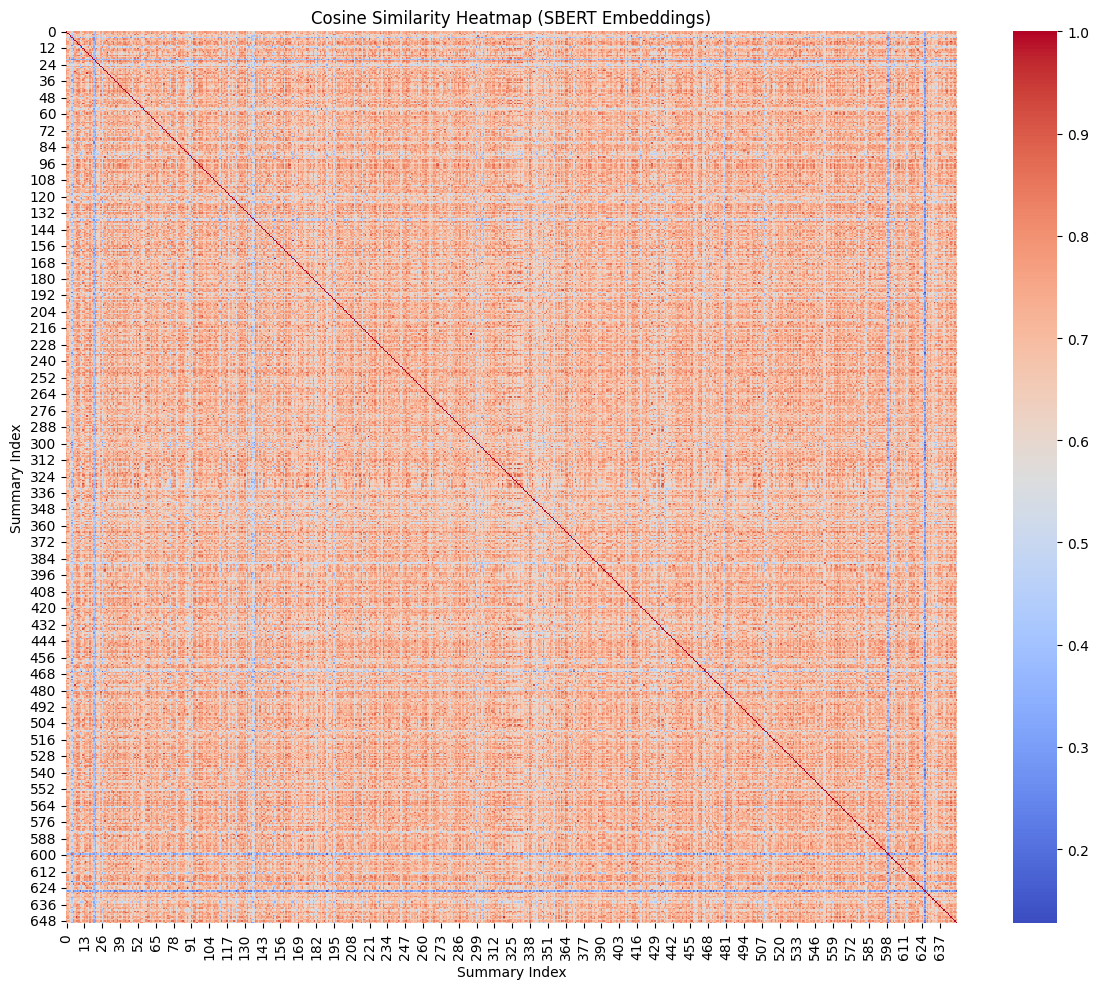

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optionally reduce size if too large
max_summaries = 650  # Adjust as needed
sim_matrix = cosine_sim_matrix_sbert[:max_summaries, :max_summaries]

plt.figure(figsize=(12, 10))
sns.heatmap(sim_matrix,cmap='coolwarm', annot=False)
plt.title("Cosine Similarity Heatmap (SBERT Embeddings)")
plt.xlabel("Summary Index")
plt.ylabel("Summary Index")
plt.tight_layout()
plt.show()


In [ ]:
!pip install keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

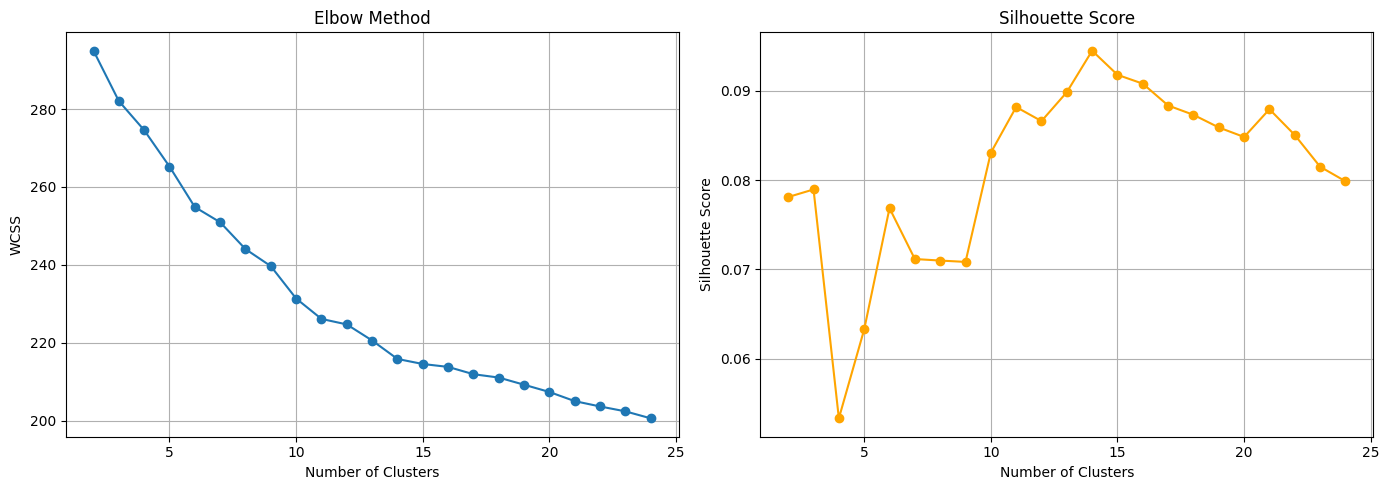

Number of clusters: 14
Number of summaries in each cluster:
Lecture_Label
0     57
1     49
2     65
3     34
4     54
5     53
6     45
7     51
8     40
9     86
10    28
11    41
12    11
13    53
Name: count, dtype: int64


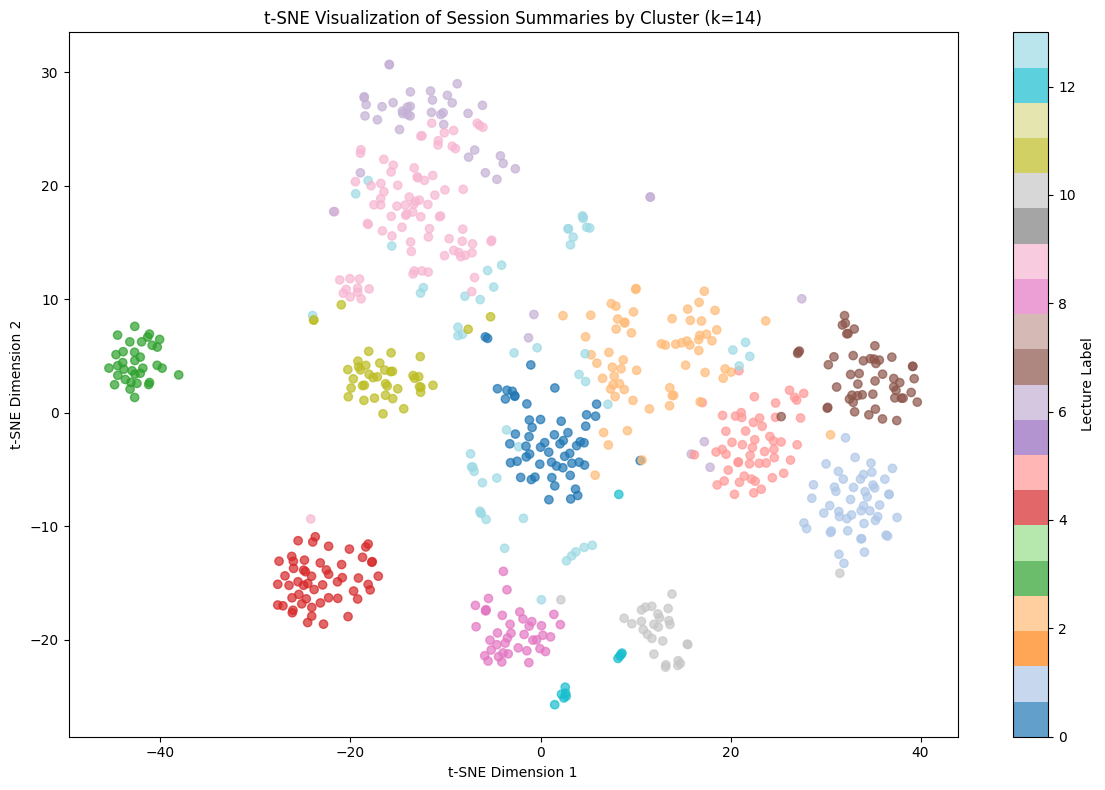

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


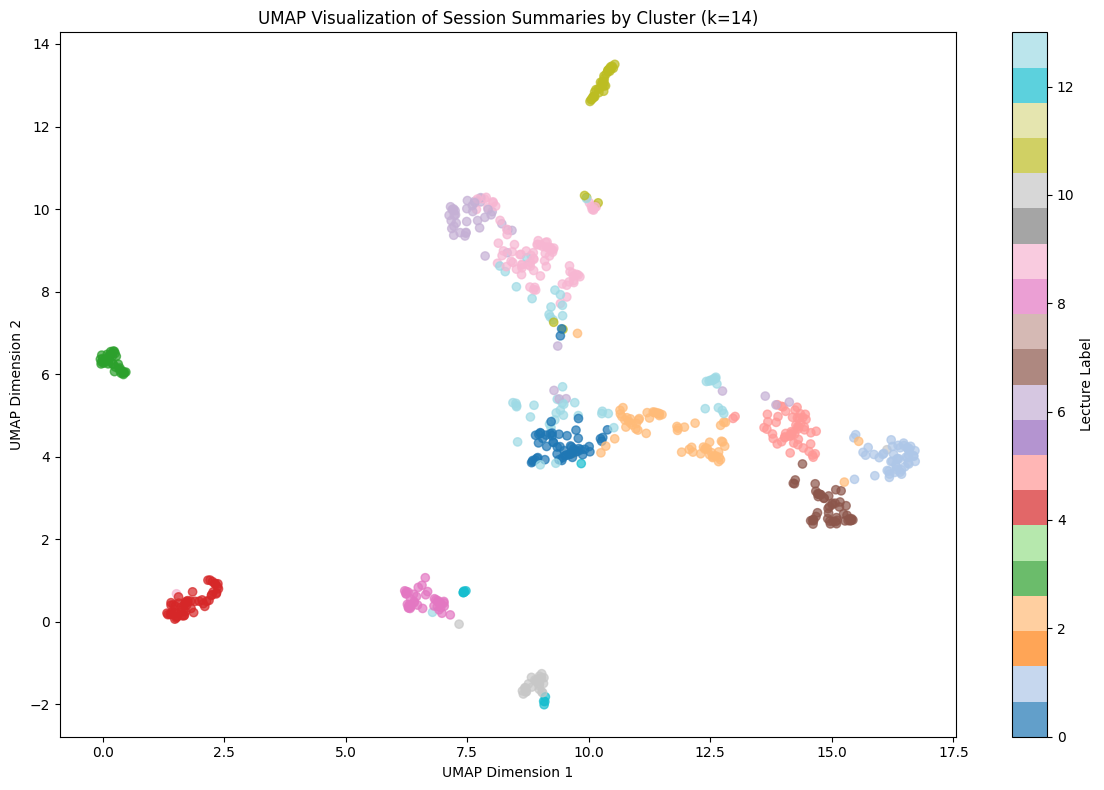

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from umap import UMAP
import tensorflow_hub as hub
from keybert import KeyBERT
import re
import html
from sklearn.metrics.pairwise import cosine_similarity

# --------  Clean Text --------
def clean_text(text):
    text = html.unescape(text)                    # Handle encoded HTML symbols
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)    # Remove non-ASCII characters (e.g. â€™)
    text = re.sub(r'\s+', ' ', text)              # Remove extra whitespace
    return text.strip()

# -------- Load and Clean Data --------
file_path = "Session-Summary-for-E6-project.xlsx"
df = pd.read_excel(file_path)

# Clean and preprocess summaries
df = df[df['Session_Summary'].notna()]
df['Session_Summary'] = df['Session_Summary'].astype(str).str.lower().str.strip()
df = df[df['Session_Summary'] != '']
df = df.drop_duplicates(subset='Session_Summary')
df = df.reset_index(drop=True)

df['Cleaned_Summary'] = df['Session_Summary'].astype(str).apply(clean_text)

summaries = df['Cleaned_Summary'].tolist()

# -------- USE Embedding --------
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Get the embeddings using USE
summary_embeddings = embed(summaries).numpy()

# -------- Clustering Evaluation --------
wcss = []
silhouette_scores = []
K = range(2, 25)  # Testing for a range of cluster values

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(summary_embeddings)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(summary_embeddings, labels))

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Method Plot
ax[0].plot(K, wcss, marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('WCSS')
ax[0].grid(True)

# Silhouette Score Plot
ax[1].plot(K, silhouette_scores, marker='o', color='orange')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid(True)

plt.tight_layout()
plt.show()

# -------- Select Optimal Number of Clusters --------
optimal_k = 14

# -------- KMeans Clustering with Optimal k --------
kmeans = KMeans(n_clusters=optimal_k, random_state=40)
df['Lecture_Label'] = kmeans.fit_predict(summary_embeddings)

# -------- Check the number of clusters --------
n_clusters = len(np.unique(df['Lecture_Label']))
print(f"Number of clusters: {n_clusters}")

# -------- Count the number of summaries in each cluster --------
cluster_counts = df['Lecture_Label'].value_counts().sort_index()
print("Number of summaries in each cluster:")
print(cluster_counts)

cluster_counts.to_csv("Cluster_Summary_Counts.csv", header=True)

# -------- t-SNE Visualization --------
tsne = TSNE(n_components=2, perplexity=30, random_state=40, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(summary_embeddings)

df['tsne-2d-one'] = tsne_results[:, 0]
df['tsne-2d-two'] = tsne_results[:, 1]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['tsne-2d-one'], df['tsne-2d-two'], c=df['Lecture_Label'], cmap='tab20', alpha=0.7)
plt.colorbar(scatter, label='Lecture Label')
plt.title(f"t-SNE Visualization of Session Summaries by Cluster (k={optimal_k})")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()

# -------- UMAP Visualization --------
umap = UMAP(n_components=2, random_state=40)
umap_results = umap.fit_transform(summary_embeddings)

df['umap-2d-one'] = umap_results[:, 0]
df['umap-2d-two'] = umap_results[:, 1]

plt.figure(figsize=(12, 8))
scatter_umap = plt.scatter(df['umap-2d-one'], df['umap-2d-two'], c=df['Lecture_Label'], cmap='tab20', alpha=0.7)
plt.colorbar(scatter_umap, label='Lecture Label')
plt.title(f"UMAP Visualization of Session Summaries by Cluster (k={optimal_k})")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()

# -------- KeyBERT Cluster Nametags --------
def generate_cluster_nametags_with_keybert(df, num_keywords=3):
    cluster_names = {}
    kw_model = KeyBERT(model='all-MiniLM-L6-v2')

    for label in sorted(df['Lecture_Label'].unique()):
        cluster_summaries = df[df['Lecture_Label'] == label]['Session_Summary'].tolist()

        if len(cluster_summaries) == 0:
            cluster_names[label] = f"Topic {label} (no data)"
            continue

        try:
            joined_text = " ".join(cluster_summaries)
            keywords = kw_model.extract_keywords(joined_text, top_n=num_keywords, stop_words='english')
            keyphrases = [kw[0] for kw in keywords]
            cluster_names[label] = ", ".join(keyphrases)
        except Exception as e:
            print(f"⚠️ Error naming cluster {label}: {e}")
            cluster_names[label] = f"Topic {label}"

    return cluster_names

# Generate cluster names
cluster_nametags = generate_cluster_nametags_with_keybert(df)
df['Lecture_Name'] = df['Lecture_Label'].map(cluster_nametags)

# -------- Cluster Centroids for Similarity Ranking --------
cluster_centroids = kmeans.cluster_centers_

# -------- Prediction Function with Confidence and Top 3 Summaries --------
def predict_cluster(input_summary, top_n=3):
    cleaned = clean_text(input_summary.lower().strip())
    embedding = embed([cleaned]).numpy()
    label = kmeans.predict(embedding)[0]
    cluster_name = cluster_nametags.get(label, f"Topic {label}")

    # Confidence: cosine similarity to the cluster centroid
    confidence = cosine_similarity(embedding, [cluster_centroids[label]])[0][0]

    # Top-N summaries closest to the cluster centroid
    cluster_data = df[df['Lecture_Label'] == label].copy()
    cluster_embeddings = embed(cluster_data['Cleaned_Summary'].tolist()).numpy()
    similarities = cosine_similarity([cluster_centroids[label]], cluster_embeddings)[0]
    cluster_data['SimilarityToCentroid'] = similarities
    top_summaries = cluster_data.sort_values(by='SimilarityToCentroid', ascending=False).head(top_n)

    print(f"Predicted Cluster: {label} ({cluster_name})")
    print(f"Prediction Confidence (Similarity to Centroid): {confidence:.4f}")
    print("\nTop Summaries in This Cluster:")
    for i, row in top_summaries.iterrows():
        print(f"- {row['Session_Summary'][:150]}...")

    return label, cluster_name, confidence, top_summaries

# Save the clustered summaries to a CSV file
df.to_csv("Clustered_Summaries.csv", index=False)


In [ ]:
predict_cluster("today we learned about computer architecture and CPU scheduling")


Predicted Cluster: 8 (classification, classifications, classify)
Prediction Confidence (Similarity to Centroid): 0.1838

Top Summaries in This Cluster:
- in our last session, we had continued to follow up on our statistical concepts based on the background we had developed earlier. we explored terms fro...
- today, we continued our discussion on statistical significance before shifting focus to python, with assigned tutorials to prepare for our next class....
- in class, we picked up from where we left off, focusing on some key statistical concepts. we talked about terms from the data analysis toolpack, what ...


(np.int32(8),
 'classification, classifications, classify',
 np.float32(0.1838158),
      SerialNo                                    Session_Summary  \
 437       438  in our last session, we had continued to follo...   
 663       665  today, we continued our discussion on statisti...   
 59         60  in class, we picked up from where we left off,...   
 
                                        Cleaned_Summary  Lecture_Label  \
 437  in our last session, we had continued to follo...              8   
 663  today, we continued our discussion on statisti...              8   
 59   in class, we picked up from where we left off,...              8   
 
      tsne-2d-one  tsne-2d-two  umap-2d-one  umap-2d-two  \
 437    -1.731164   -17.308619     8.790311     6.367887   
 663    -2.501327     8.716424    10.654085     6.064406   
 59     -0.965808   -16.775951     8.866447     6.419978   
 
                                   Lecture_Name  SimilarityToCentroid  
 437  classification, clas

In [ ]:
# -------- Bubble Chart Visualization (Keyword Density by Session) --------
from keybert import KeyBERT
import plotly.express as px

print("🔍 Creating Session Bubble Chart based on KeyBERT keywords...")

# Initialize KeyBERT with MiniLM
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

session_keywords = {}
keyword_counts = []

# Calculate keywords per cluster
for cluster_id in sorted(df['Lecture_Label'].unique()):
    cluster_summaries = df[df['Lecture_Label'] == cluster_id]['Cleaned_Summary'].tolist()
    combined_text = " ".join(cluster_summaries)

    try:
        candidates = kw_model.extract_keywords(
            combined_text,
            keyphrase_ngram_range=(1, 2),
            stop_words='english',
            top_n=100
        )

        # Filter keywords above threshold
        threshold = 0.4
        keywords = [(kw, score) for kw, score in candidates if score >= threshold]
        session_keywords[cluster_id] = dict(keywords)
        keyword_counts.append(len(keywords))

    except Exception as e:
        print(f"⚠ Error extracting keywords from cluster {cluster_id}: {e}")
        session_keywords[cluster_id] = {}
        keyword_counts.append(0)

# Prepare DataFrame for bubble chart
bubble_df = pd.DataFrame({
    'Session': [f'Session {i}' for i in range(len(keyword_counts))],
    'Keyword Count': keyword_counts,
    'Cluster ID': list(range(len(keyword_counts)))
})

# Create and display the bubble chart
fig = px.scatter(
    bubble_df,
    x='Cluster ID',
    y='Keyword Count',
    size='Keyword Count',
    hover_name='Session',
    title='📘 Sessions Bubble Chart (Keyword Density per Cluster)',
    labels={'Keyword Count': 'BERT Keywords (Score ≥ 0.4)'},
    size_max=60
)

fig.show()

🔍 Creating Session Bubble Chart based on KeyBERT keywords...


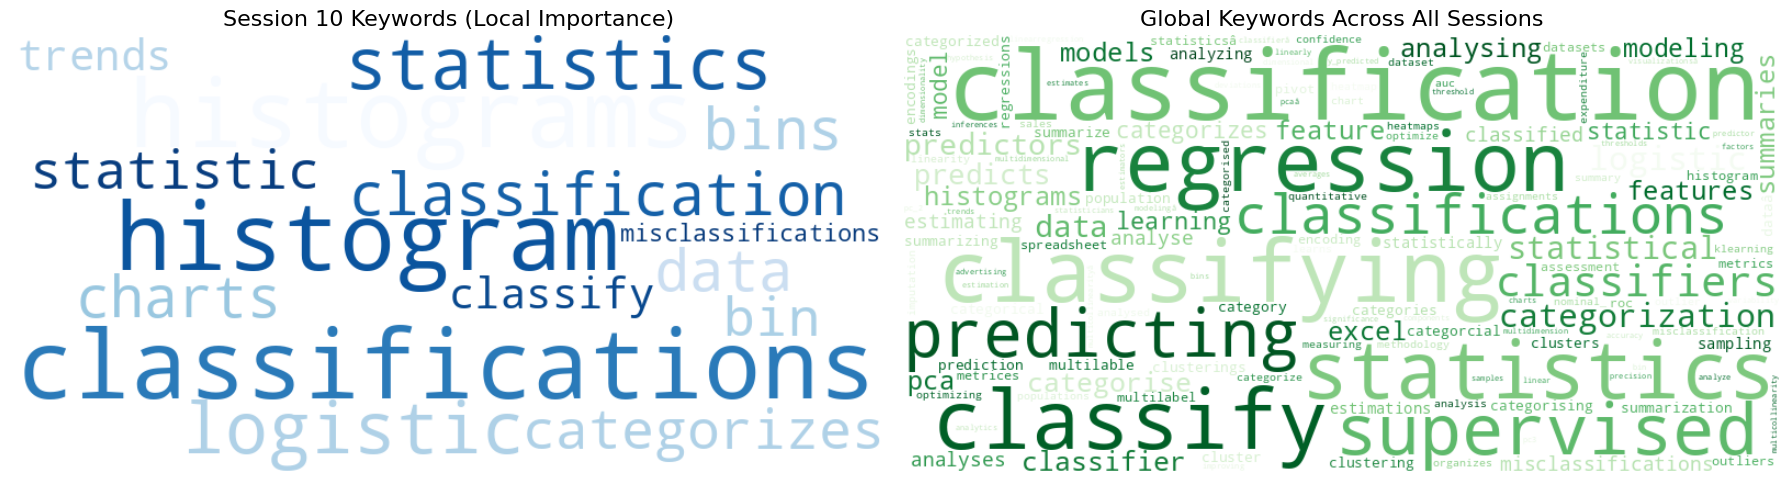

In [ ]:
from keybert import KeyBERT
from collections import defaultdict

# Initialize KeyBERT model
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

# Dictionary to hold keywords per session (cluster)
session_keywords = defaultdict(dict)

# Extract keywords for each session
for label in sorted(df['Lecture_Label'].unique()):
    session_text = " ".join(df[df['Lecture_Label'] == label]['Session_Summary'].tolist())
    keywords = kw_model.extract_keywords(session_text, top_n=15, stop_words='english')

    # Store keyword:score mapping
    session_keywords[label] = {kw[0]: kw[1] for kw in keywords}

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Choose a session (cluster) ID
session_id = 10  # Change this to view another cluster

# Get keywords for the selected session
session_kw = session_keywords.get(session_id, {})
if not session_kw:
    print(f"No keywords found for session {session_id}")
else:
    # Session-specific word cloud
    session_wc = WordCloud(width=800, height=400, background_color='white',
                           colormap='Blues').generate_from_frequencies(session_kw)

    # Global keyword frequency
    global_kw_freq = Counter()
    for kws in session_keywords.values():
        global_kw_freq.update(kws)

    global_wc = WordCloud(width=800, height=400, background_color='white',
                          colormap='Greens').generate_from_frequencies(global_kw_freq)

    # Plot both
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes[0].imshow(session_wc, interpolation='bilinear')
    axes[0].set_title(f"Session {session_id} Keywords (Local Importance)", fontsize=16)
    axes[0].axis('off')

    axes[1].imshow(global_wc, interpolation='bilinear')
    axes[1].set_title("Global Keywords Across All Sessions", fontsize=16)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr

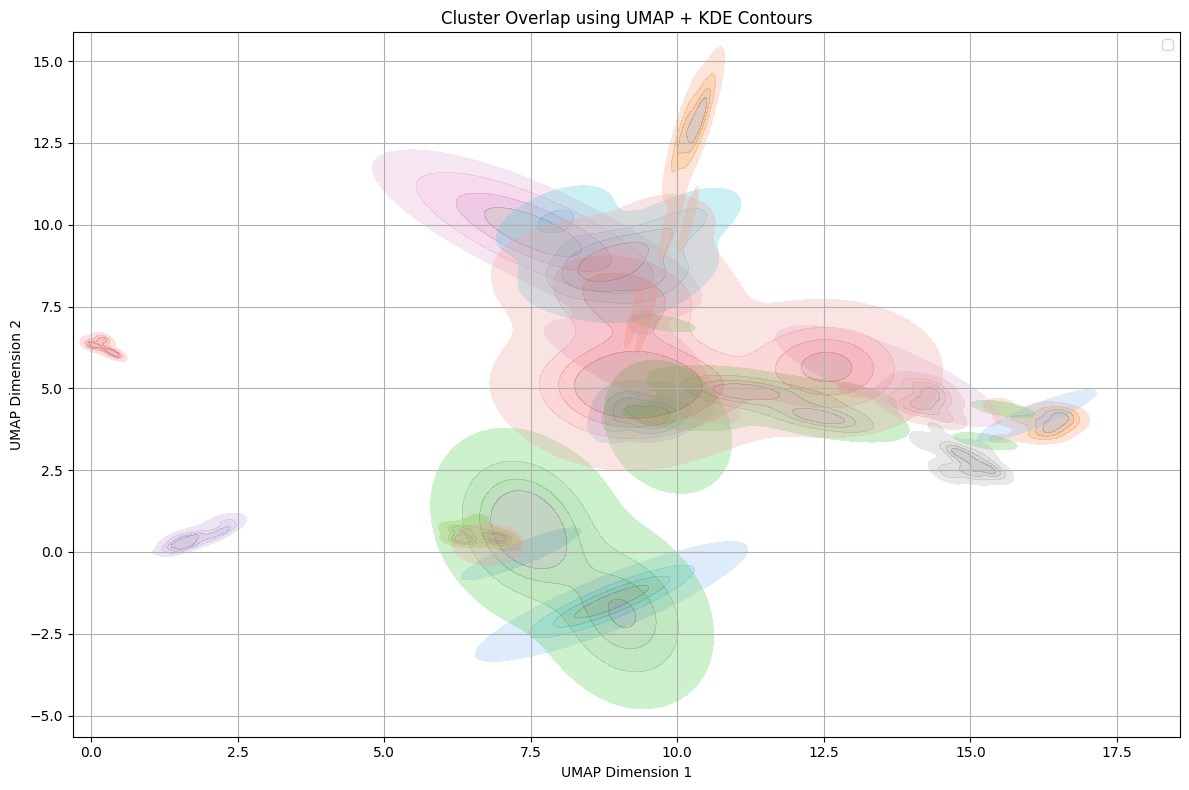

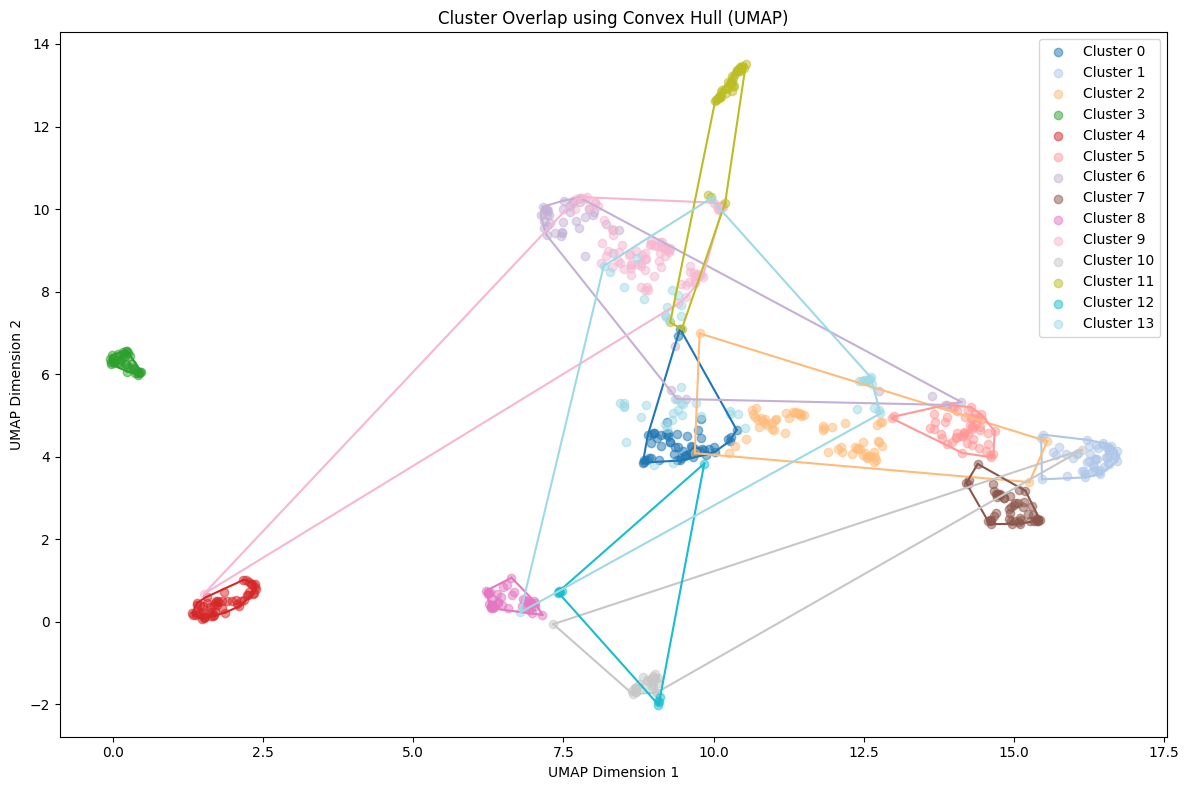

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))
for label in sorted(df['Lecture_Label'].unique()):
    subset = df[df['Lecture_Label'] == label]
    sns.kdeplot(
        x=subset['umap-2d-one'],
        y=subset['umap-2d-two'],
        fill=True,
        label=f'Cluster {label}',
        alpha=0.3,
        linewidth=1,
        levels=5
    )

plt.title("Cluster Overlap using UMAP + KDE Contours")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from scipy.spatial import ConvexHull
import matplotlib.cm as cm

plt.figure(figsize=(12, 8))
colors = cm.tab20(np.linspace(0, 1, len(df['Lecture_Label'].unique())))

for i, label in enumerate(sorted(df['Lecture_Label'].unique())):
    cluster_data = df[df['Lecture_Label'] == label][['umap-2d-one', 'umap-2d-two']].values

    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {label}', alpha=0.5, color=colors[i])

    if len(cluster_data) >= 3:
        hull = ConvexHull(cluster_data)
        for simplex in hull.simplices:
            plt.plot(cluster_data[simplex, 0], cluster_data[simplex, 1], color=colors[i])

plt.title("Cluster Overlap using Convex Hull (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()
